<a href="https://colab.research.google.com/github/OMONa-E/Datetime-Data-Analysis/blob/main/Chicago_Crime_Data_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
> **Author: *Omona Emmanuel***


##### Mount Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Folder path
fpath = '/content/drive/MyDrive/CodingDojo/04-DataViz/Week13/Data/Data/Chicago'

##### Imports Packages

In [ ]:
!pip install pmdarima

In [50]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
# set display to 100 maximum columns
pd.set_option('display.max_columns',100)
import glob

##### Load data and Inspect

In [5]:
try:
  crime_files = sorted(glob.glob(fpath+"*.csv"))
  df = pd.concat([pd.read_csv(f) for f in crime_files])
  print('Successful')

except Exception:
  print('Check file path or object to concat if exists')

Successful


In [6]:
# make a copy
crime_df = df.copy()

In [7]:
display(df.info(verbose=True, show_counts=True), crime_df.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    7713109 non-null  int64  
 1   Date                  7713109 non-null  object 
 2   Primary Type          7713109 non-null  object 
 3   Description           7713109 non-null  object 
 4   Location Description  7702181 non-null  object 
 5   Arrest                7713109 non-null  bool   
 6   Domestic              7713109 non-null  bool   
 7   Beat                  7713109 non-null  int64  
 8   District              7713062 non-null  float64
 9   Ward                  7098263 non-null  float64
 10  Latitude              7624424 non-null  float64
 11  Longitude             7624424 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


None

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970


In [8]:
# converting date dtype and dropping NaT
crime_df['Date'] = pd.to_datetime(crime_df['Date'], errors='coerce')
crime_df = crime_df.dropna(subset=['Date'])
## setting index and sorting
crime_df.set_index('Date', inplace=True)
crime_df.sort_index(inplace=True)

crime_df.head(2)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01,3214584,THEFT,FINANCIAL ID THEFT: OVER $300,STREET,False,False,2221,22.0,21.0,41.732563,-87.669923
2001-01-01,1927872,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,812,8.0,NaN,41.778094,-87.770137


#### Comparing Police Districts
>Which district had the most crimes in 2022?
>`8.0`

>Which had the least?
`31.0`

In [9]:
# crime by year
crime_df['year'] = crime_df.index.year
# groupby quering and sorting from min to max
crime_by_year_2022 = crime_df.query('year == 2022').groupby(['District'])['year'].value_counts().sort_values()
# converting to Dataframe dtype
crime_yr = crime_by_year_2022.to_frame().reset_index()
# displaying min, max and dataframe
print(f'''
{'-'*30}
      Minimun_Crime_2022_District: {crime_yr.loc[0, 'District']}
      Maximun_Crime_2022_District: {crime_yr.loc[(len(crime_yr)-1), 'District']}
{'-'*30}\n''')
display(crime_yr)


------------------------------
      Minimun_Crime_2022_District: 31.0
      Maximun_Crime_2022_District: 8.0
------------------------------



,District,year,count
0,31.0,2022,15
1,20.0,2022,4960
2,17.0,2022,6997
3,22.0,2022,7671
4,14.0,2022,8158
5,15.0,2022,8308
6,24.0,2022,8469
7,16.0,2022,9226
8,5.0,2022,9773
9,10.0,2022,9961


In [10]:
# crime_df.loc['2022', 'District']

#### Crimes Across the Years:

>Is the total number of crimes increasing or decreasing across the years?
> `We see steady flow down of total crime from the 2001 to 2021 and a slight increased in the year 2022`

>Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?
> `Yes, there're some individual crimes that are contrary to the general trend as seen the plots`​

In [11]:
# creating Dataframe for year trend
overall_crimes_across_years = crime_df['year'].value_counts().to_frame().reset_index()
overall_crimes_across_years.head(3)

,year,count
0,2002,486807
1,2001,485886
2,2003,475985


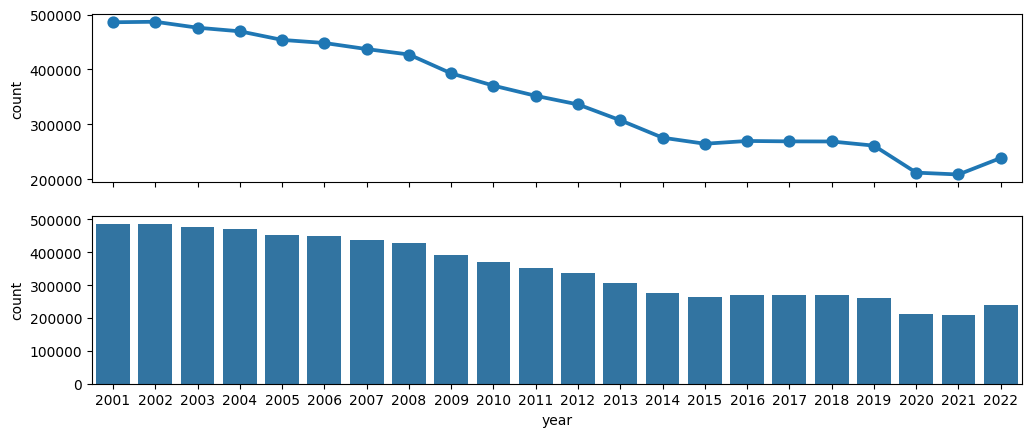

In [12]:
# plotting point graph to determine trend
fig, ax = plt.subplots(nrows=2, sharex=True);
fig.set_figwidth(12)
sns.pointplot(overall_crimes_across_years, x='year', y='count', ax=ax[0]);
sns.barplot(overall_crimes_across_years, x='year', y='count', ax=ax[1]);

In [13]:
# checking occurence of crime
crime_df['Primary Type'].nunique(), crime_df['Description'].nunique()

(36, 547)

In [14]:
## individual crime through the years range
# we shall use Primary Type since has low occurence
overall_each_crime = crime_df.groupby(['Primary Type'])['year'].value_counts().sort_values().to_frame().reset_index()

overall_each_crime

,Primary Type,year,count
0,RITUALISM,2007,1
1,NON-CRIMINAL,2009,1
2,RITUALISM,2004,1
3,RITUALISM,2020,1
4,NON-CRIMINAL (SUBJECT SPECIFIED),2014,1
...,...,...,...
684,BATTERY,2002,94153
685,THEFT,2004,95463
686,THEFT,2002,98332
687,THEFT,2003,98876


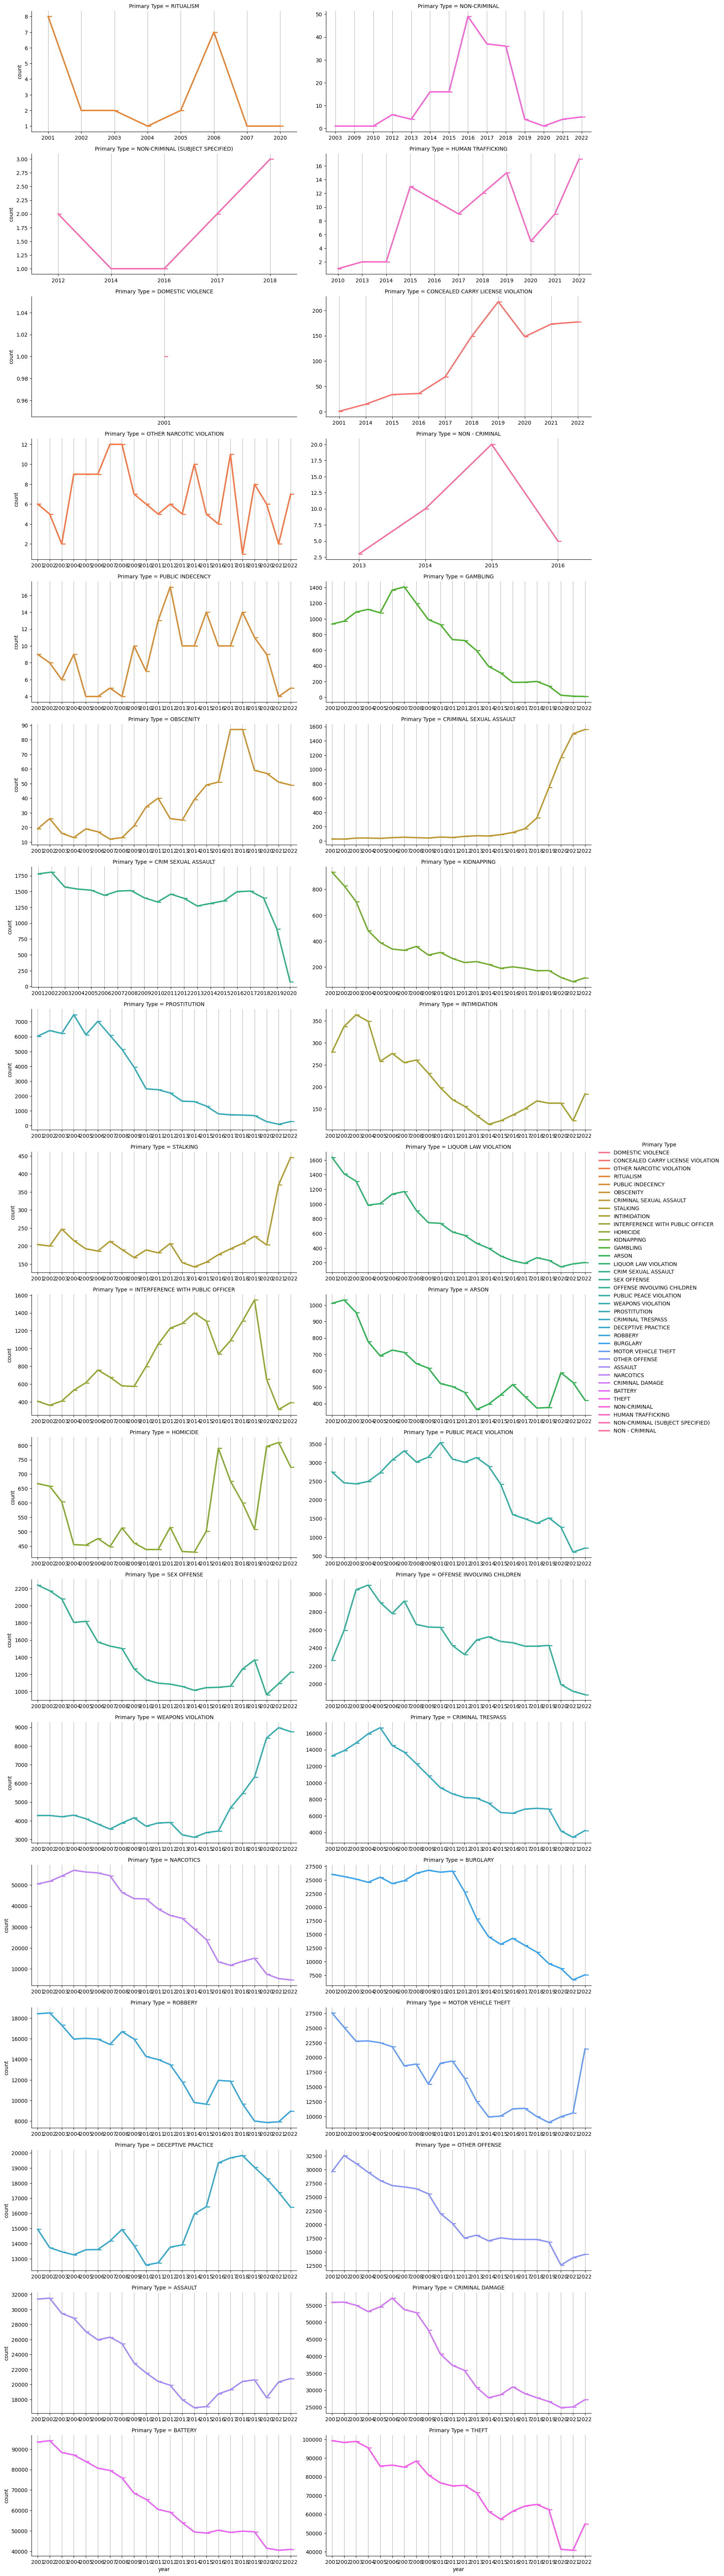

In [15]:
# fig, ax = plt.subplots(figsize=(13, 4))
pl = sns.catplot(data=overall_each_crime, x='year', y='count', markers=True, kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in pl.axes];

#### What cycles (seasonality) can you find in this data?
>(Total Crime (Monthly))

​How long is a cycle?
`365 days`

​What is the magnitude of the cycle? (Compare min and max).
`~8897.74`

In [16]:
# making dataframe for total crime using primary type and index-datetime of crime
crime_total_ts = crime_df['Primary Type'].index.value_counts().to_frame()
crime_total_ts.head(3)

,count
Date,
2008-01-01 00:01:00,304
2007-01-01 00:01:00,259
2006-01-01 00:01:00,226


In [17]:
# checking for null values
crime_total_ts.isnull().sum()

count    0
dtype: int64

In [18]:
# resampling on monthly
crime_total_ts_monthly = crime_total_ts.resample('M').sum()
crime_total_ts_monthly.head(3)

,count
Date,
2001-01-31,38119
2001-02-28,33787
2001-03-31,40566


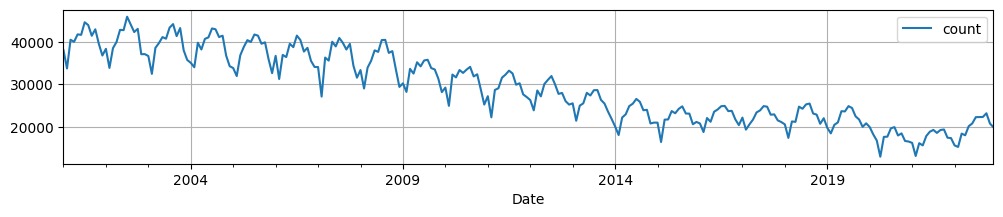

In [19]:
# visualizing without seasonality
crime_total_ts_monthly.plot(grid=True, figsize=(12,2));

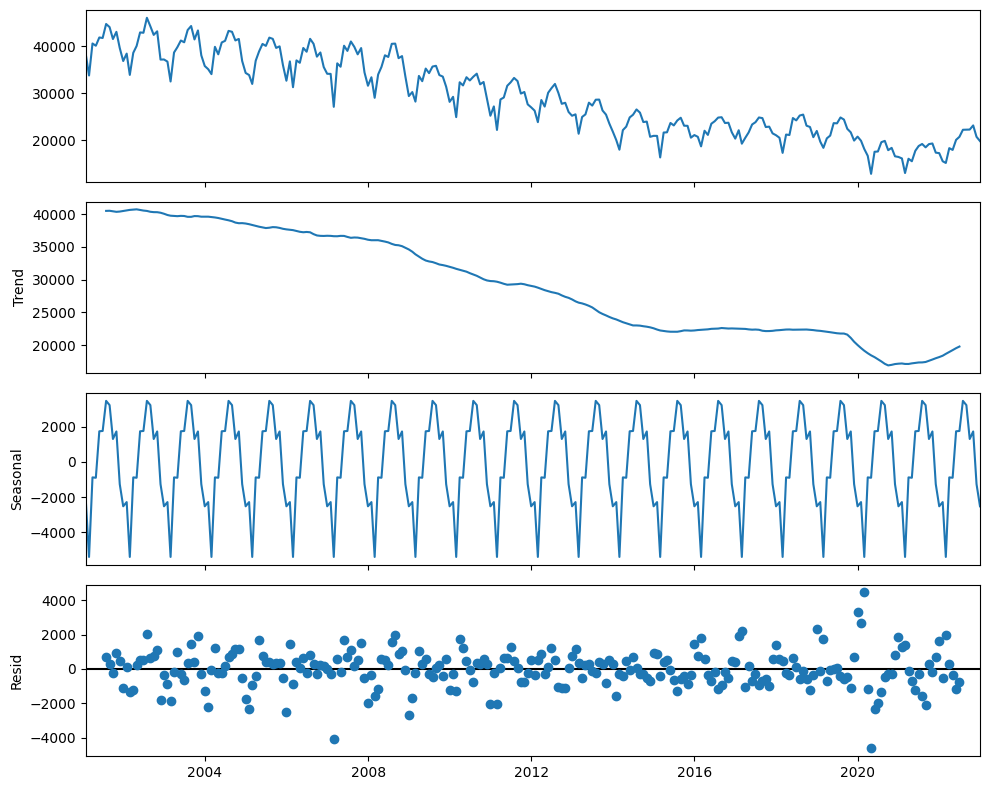

In [20]:
# seasonality ploting
decomp_monthly = tsa.seasonal_decompose(crime_total_ts_monthly)

# plot decomposed
fig = decomp_monthly.plot()
fig.set_size_inches(10, 8)
fig.tight_layout()

In [21]:
# custom function for ploting
def plot_seasonal(seasonal):
    minor_loc = mdates.MonthLocator()
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(seasonal)
    ax.set(title=f'Seasonal Component for Total Monthly Occurence of Crime');
    ax.xaxis.set_minor_locator(minor_loc)
    ax.grid(which='major', axis='x',lw=1, color='k')
    ax.grid(which='minor',axis='x',lw=0.5)
    fig.autofmt_xdate(rotation=90, ha='center')

    return fig, ax

In [22]:
# calculating cycle of occurence
from scipy.signal import find_peaks

# define seasonal
seasonal_monthly = decomp_monthly.seasonal
# definding peaks and props
peaks, props = find_peaks(seasonal_monthly, height=seasonal_monthly.max())

peaks, props

(array([  6,  18,  30,  42,  54,  66,  78,  90, 102, 114, 126, 138, 150,
        162, 174, 186, 198, 210, 222, 234, 246, 258]),
 {'peak_heights': array([3481.65542328, 3481.65542328, 3481.65542328, 3481.65542328,
         3481.65542328, 3481.65542328, 3481.65542328, 3481.65542328,
         3481.65542328, 3481.65542328, 3481.65542328, 3481.65542328,
         3481.65542328, 3481.65542328, 3481.65542328, 3481.65542328,
         3481.65542328, 3481.65542328, 3481.65542328, 3481.65542328,
         3481.65542328, 3481.65542328])})

In [23]:
# definding peaks dates
peaks_dt = seasonal_monthly.index[peaks]

peaks_dt

DatetimeIndex(['2001-07-31', '2002-07-31', '2003-07-31', '2004-07-31',
               '2005-07-31', '2006-07-31', '2007-07-31', '2008-07-31',
               '2009-07-31', '2010-07-31', '2011-07-31', '2012-07-31',
               '2013-07-31', '2014-07-31', '2015-07-31', '2016-07-31',
               '2017-07-31', '2018-07-31', '2019-07-31', '2020-07-31',
               '2021-07-31', '2022-07-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [24]:
# periodic cycle
period = peaks_dt[1] - peaks_dt[0]

# fluctuation
delta = seasonal_monthly.max() - seasonal_monthly.min()

period, delta

(Timedelta('365 days 00:00:00'), 8897.74404761905)

There is seasonality in the years span crime reports with a period of 365 days 00:00:00,
with an overall seasonal fluctuation of ~8897.74404761905 crimes per month



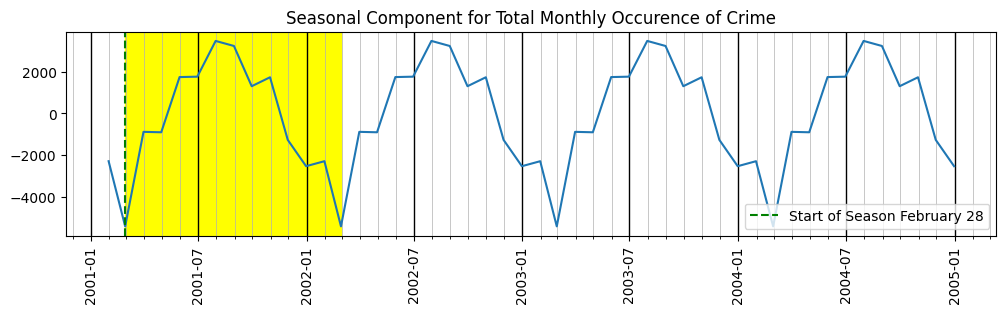

In [25]:
# ploting seasonal graph
fig, ax = plot_seasonal(seasonal_monthly.loc['2000' : '2004'])
# shading periodic zone
ax.axvspan(seasonal_monthly.idxmin(), (seasonal_monthly.idxmin() + period), color='yellow');
# adding aline start at the period span
ax.axvline(seasonal_monthly.idxmin(), color='green', ls='--', label=f"Start of Season {seasonal_monthly.idxmin().strftime('%B %d')}")
ax.legend();
print(f'''There is seasonality in the years span crime reports with a period of {period},
with an overall seasonal fluctuation of ~{delta} crimes per month\n''')

#### Forecasting for Narcotics and Total Crime

In [26]:
# define NARCOTICS crime
narco_ts = crime_df['Primary Type'][crime_df['Primary Type'] == 'NARCOTICS'].index.value_counts()

# resample to monthly using size
narco_ts = narco_ts.resample('M').size()

narco_ts.index

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=264, freq='M')

In [27]:
# define Total crime
total_crime_ts = crime_df['Primary Type'].index.value_counts()

# resample to monthly using size
total_crime_ts = total_crime_ts.resample('M').size()

total_crime_ts.index

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=264, freq='M')

In [34]:
## checking for and addressing null values
print(f'{narco_ts.isna().sum()} # null - narcotics time series\n{total_crime_ts.isnull().sum()} # null - total crime time series')

0 # null - narcotics time series
0 # null - total crime time series


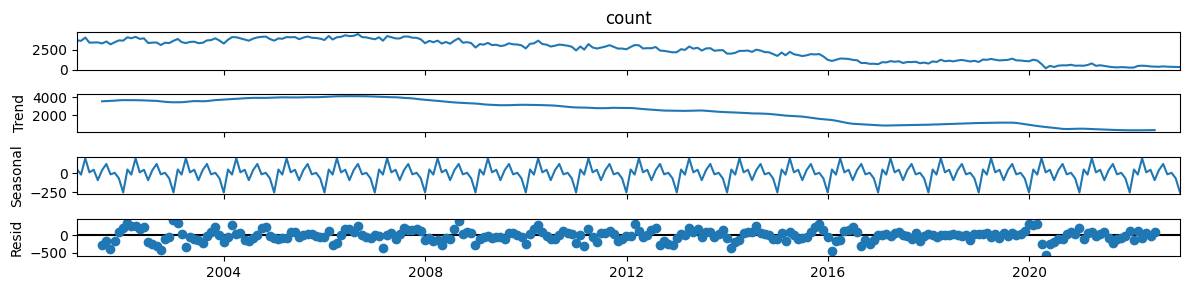

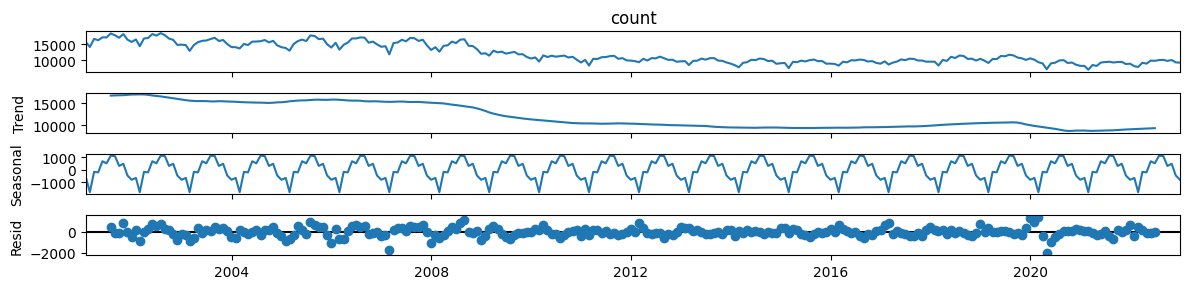

In [38]:
## Decomposing the Time series to detect seasonality and deciding whether to use a seasonal model or not

# narco_ts
decomp_narco = tsa.seasonal_decompose(narco_ts)
# narco_ts decomp plot
ax = decomp_narco.plot()
ax.set_size_inches(12, 3)
ax.tight_layout();

# total_crime_ts
decomp_total = tsa.seasonal_decompose(total_crime_ts)
# total_crime_ts plot
ax1 = decomp_total.plot()
ax1.set_size_inches(12, 3)
ax1.tight_layout()

----------------------------------------
The total crime seasonal component is  2904.63 which is ~25.34% of the variation in time series.
----------------------------------------


----------------------------------------
The narco seasonal component is  443.08 which is ~10.25% of the variation in time series.
----------------------------------------




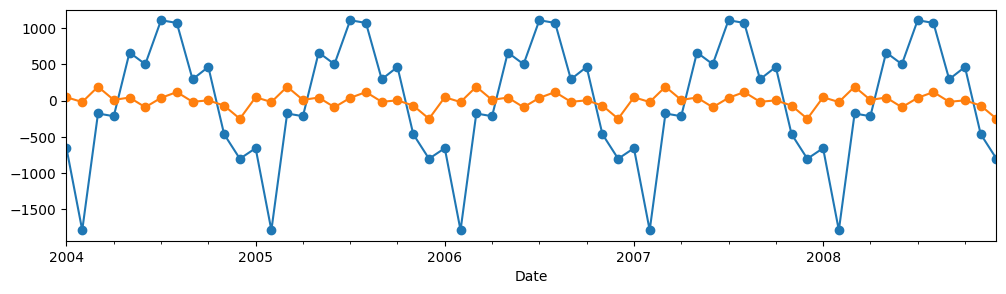

In [47]:
## Since we have seasonal occurences on both time series
## we plot on expanded scale to view the period of each

### total crime seasonal plot
seasonal_total = decomp_total.seasonal
ax = seasonal_total.loc['2004': '2008'].plot(marker = 'o')
ax.figure.set_size_inches(12, 3)
## total crime seasonal component
total_seasonal_delta = decomp_total.seasonal.max() - decomp_total.seasonal.min()
# How big is the total crime seasonal component relative to the time series?
print(f"{'--'*20}\nThe total crime seasonal component is {total_seasonal_delta: .2f} which is ~{total_seasonal_delta/(total_crime_ts.max()-total_crime_ts.min()) * 100 :.2f}% of the variation in time series.\n{'--'*20}\n\n")


### narcotics crime seasonal plot
seasonal_narco = decomp_narco.seasonal
ax1 = seasonal_narco.loc['2004': '2008'].plot(marker = 'o')
## total crime seasonal component
narco_seasonal_delta = decomp_narco.seasonal.max() - decomp_narco.seasonal.min()
# How big is the total crime seasonal component relative to the time series?
print(f"{'--'*20}\nThe narco seasonal component is {narco_seasonal_delta: .2f} which is ~{narco_seasonal_delta/(narco_ts.max()-narco_ts.min()) * 100 :.2f}% of the variation in time series.\n{'--'*20}\n\n")



```
# The seasonal period for both time series are 12
### m - narco_ts = 12
### m - total crime = 12
```



In [54]:
# Determining if nonseasonal and/or seasonal differencing is required for each time series

### narco_ts differencing
d_narco = ndiffs(narco_ts)
D_narco = nsdiffs(narco_ts, m=12)

### total_crime_ts differencing
d_total = ndiffs(total_crime_ts)
D_total = nsdiffs(total_crime_ts, m=12)

print(f"""narco diff: {d_narco}\nnarco sdiff: {D_narco}\n
total diff: {d_total}\ntotal sdiff: {D_total}""")

narco diff: 1
narco sdiff: 0

total diff: 1
total sdiff: 0




```
# We see that both time series needs (1) nonseasonal differencing
## They require zero seasonal differencing
```



In [57]:
# @title ACF vs PACF Func
def get_sig_lags(ts, type='ACF', nlags=None, alpha=0.5):
    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)

    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)

    else:
        raise Exception("type must be either 'ACF' or 'PACF'")

    # Determine lags
    lags =range(len(corr_values))

    # Create a centered version of the acf_df
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")

    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags

def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()

    return fig

In [58]:
# @title Evaluation Func
def evaluate_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  mae_perc = mean_absolute_percentage_error(y_true, y_pred) * 100
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
    print(f"- MAPE = {mae_perc:,.2f}%")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared, "MAPE(%)": mae_perc,}
      return metrics

In [59]:
# @title Forecast Plot Func
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

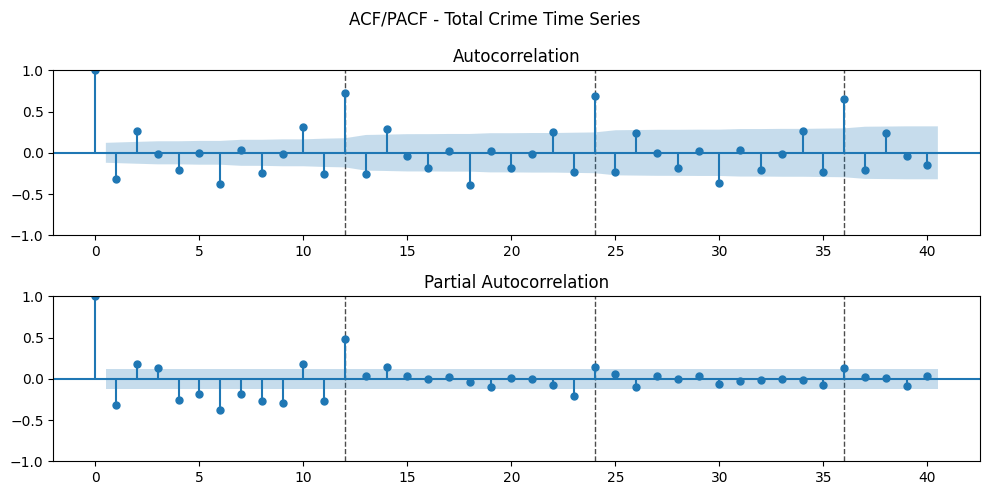

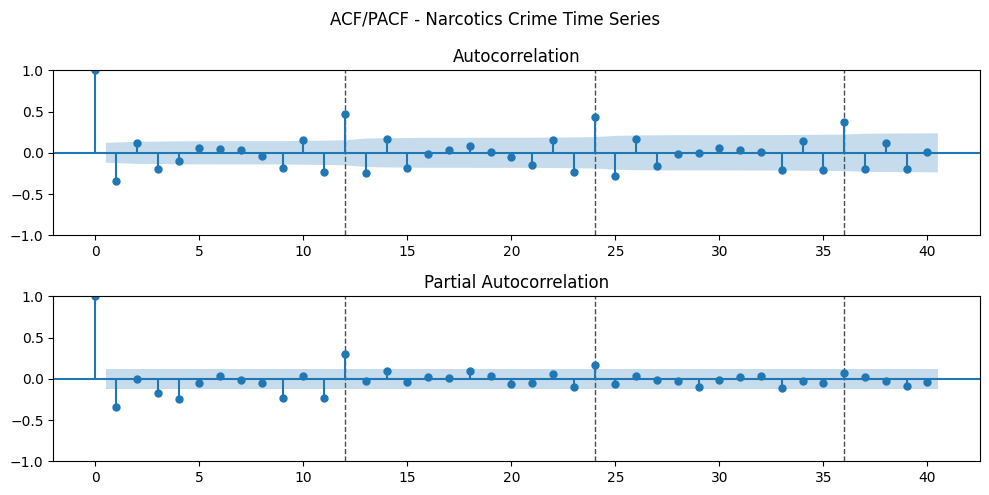

In [68]:
# Using the ACF and PACF plots of stationarity data to estimate initial orders

### total crime ACF/PACF
# performing nonseasonal differing
total_diff = total_crime_ts.diff().dropna()
# plot
fig1 = plot_acf_pacf(total_diff, nlags=40, annotate_seas=True, m = 12)
fig1.suptitle('ACF/PACF - Total Crime Time Series')
fig1.tight_layout();

### narco ACF/PACF
# performing nonseasonal differing
narco_diff = narco_ts.diff().dropna()
# plot
fig2 = plot_acf_pacf(narco_diff, annotate_seas=True, m = 12)
fig2.suptitle('ACF/PACF - Narcotics Crime Time Series')
fig2.tight_layout();



```
## ACF - We a periodic significant spikes at every 12 intervals with a general gradual drop
## PACF - We see a genearal gradual drop with significant spikes at 1

### we starts with orders of (1,d,1) and (1,D,1)
```



In [72]:
# Splitting the time series into training and test data (To predict/forecast 6 months)
## train test split

### narcotics crime split
train_narco, test_narco = train_test_split(narco_ts, test_size=6)

### total crime split
train_total, test_total = train_test_split(total_crime_ts, test_size=6)

# printing the percent test
print(f"""Narco test perc: {(len(test_narco)/len(narco_ts)) * 100}
Total Crime perc: {(len(test_total)/len(total_crime_ts)) * 100}""")

Narco test perc: 2.27
Total Crime perc: 2.27


------------------------------------------------------------
Regression Metrics: Total Crime Metrics
------------------------------------------------------------
- MAE = 182.345
- MSE = 46,621.628
- RMSE = 215.920
- R^2 = 0.629
- MAPE = 1.87%
------------------------------------------------------------
Regression Metrics: Narcotics Crime Metrics
------------------------------------------------------------
- MAE = 59.731
- MSE = 4,963.364
- RMSE = 70.451
- R^2 = -4.836
- MAPE = 17.40%


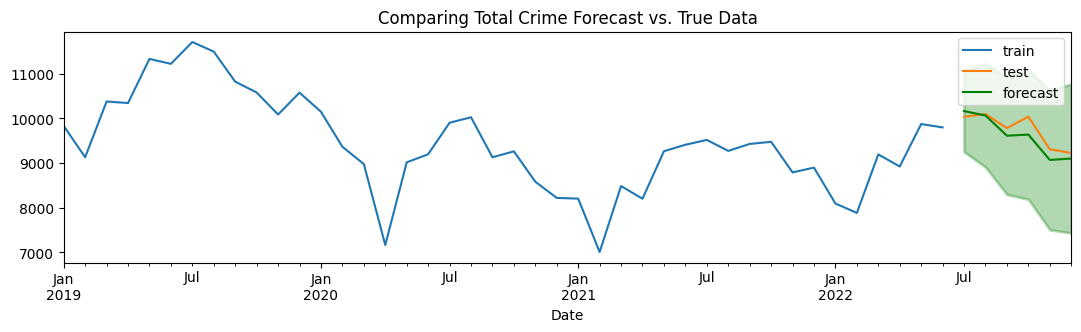

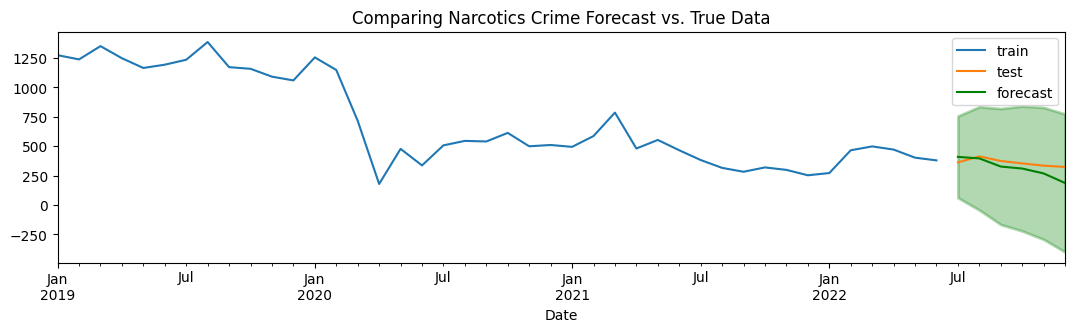

In [80]:
# Fitting a manual ARIMA/SARIMA model based on the orders determined during exploration.
## ARIMA/SARIMA fitting

### narcotics crime fitting
# narco params
pdq_narco = (1, d_narco, 1)
PDQm_narco = (1, D_narco, 1, 12)
# fit
model_narco = tsa.ARIMA(train_narco, order=pdq_narco, seasonal_order=PDQm_narco).fit()

### total crime fitting
# total crime params
pdq_total = (1, d_total, 1)
PDQm_total = (1, D_total, 1, 12)
# fit
model_total = tsa.ARIMA(train_total, order=pdq_total, seasonal_order=PDQm_total).fit()



##### Make forecasts with your model.
# narcotics time series
narco_forecast = model_narco.get_forecast(len(test_narco)).summary_frame()
# total crime time series
total_forecast = model_total.get_forecast(len(test_total)).summary_frame()



##### Plot the forecasts versus the test data
# plot forecast expanding from 2019 onwards
## total plot
plot_forecast(train_total.loc['2019':], test_total, total_forecast, title='Comparing Total Crime Forecast vs. True Data', figsize=(13, 3));
## narco plot
plot_forecast(train_narco.loc['2019':], test_narco, narco_forecast, title='Comparing Narcotics Crime Forecast vs. True Data', figsize=(13, 3));



##### Obtain metrics for evaluation
## total evaluate_metrics
evaluate_metrics(test_total, total_forecast['mean'], label='Total Crime Metrics')
## narcotics evaluate_metrics
evaluate_metrics(test_narco, narco_forecast['mean'], label='Narcotics Crime Metrics')

In [84]:
# Tunning with pmdarima's auto_arima
## total time series tunning
tune_total_model = pm.auto_arima(total_crime_ts, trace=True, m=12, seasonal=True)
## narcotics time series tunning
tune_narco_model = pm.auto_arima(narco_ts, trace=True, m=12, seasonal=True)

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 703, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4323.823, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4114.893, Time=1.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4203.809, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4322.019, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4295.210, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4075.848, Time=2.36 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4039.824, Time=3.73 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4040.026, Time=1.28 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4083.694, Time=4.50 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=4098.547, Time=2.39 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=4041.982, Time=3.40 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=4082.224, Time=3.55 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4076.205, Time=5.07 sec
 ARIMA

------------------------------------------------------------
Regression Metrics: Tuned Total Crime Metrics
------------------------------------------------------------
- MAE = 182.345
- MSE = 46,621.628
- RMSE = 215.920
- R^2 = 0.629
- MAPE = 1.87%
------------------------------------------------------------
Regression Metrics: Tuned Narcotics Crime Metrics
------------------------------------------------------------
- MAE = 59.731
- MSE = 4,963.364
- RMSE = 70.451
- R^2 = -4.836
- MAPE = 17.40%


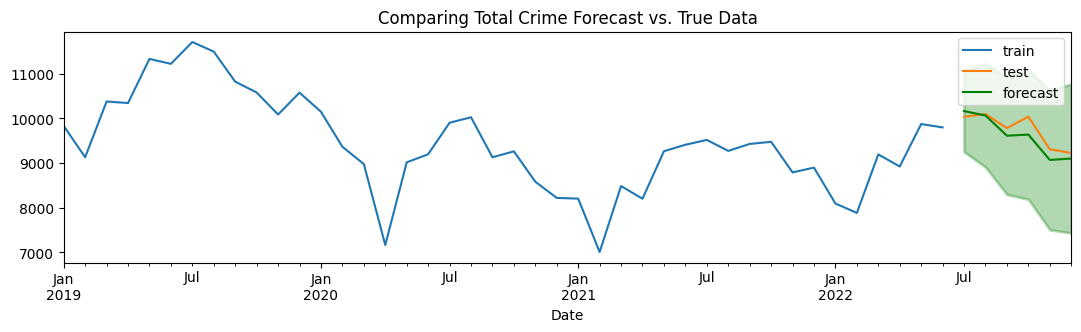

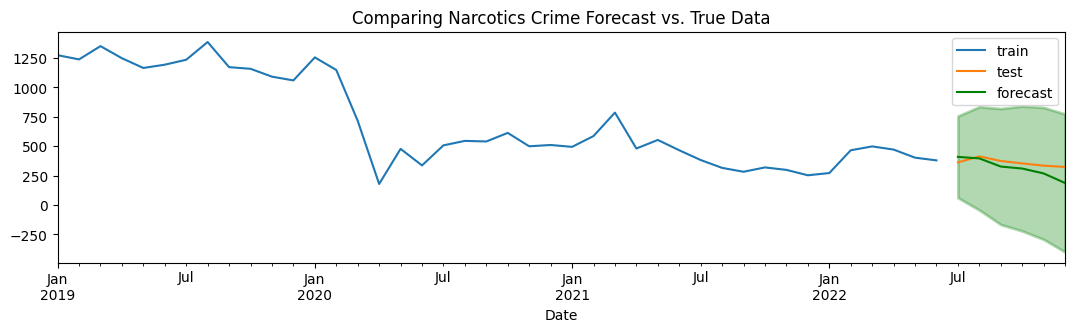

In [85]:
# Fit a model on training data with the best parameters from auto_arima
## narcotics time series
#### tuned params - ARIMA(0,1,4)(1,0,1)[12]
pdq_tune_narco = (0,1,4)
PDQm_tune_narco = (1,0,1,12)
# fitting model
auto_narco_model = tsa.ARIMA(train_narco, order=pdq_tune_narco, seasonal_order=PDQm_tune_narco).fit()

## total crime time series
#### tuned params - ARIMA(0,1,1)(1,0,1)[12]
pdq_tune_total = (0,1,1)
PDQm_tune_total = (1,0,1,12)
# fitting model
auto_total_model = tsa.ARIMA(train_total, order=pdq_tune_total, seasonal_order=PDQm_tune_total).fit()




# Make forecasts with the auto_arima model
### narcotics time series
narco_tune_forecast = model_narco.get_forecast(len(test_narco)).summary_frame()
### total crime time series
total_tune_forecast = model_total.get_forecast(len(test_total)).summary_frame()



# Plot the forecasts versus the test data
# plot forecast expanding from 2019 onwards
## total plot
plot_forecast(train_total.loc['2019':], test_total, total_tune_forecast, title='Comparing Total Crime Forecast vs. True Data', figsize=(13, 3));
## narco plot
plot_forecast(train_narco.loc['2019':], test_narco, narco_tune_forecast, title='Comparing Narcotics Crime Forecast vs. True Data', figsize=(13, 3));



# Obtain metrics for evaluation
## total evaluate_metrics
evaluate_metrics(test_total, total_tune_forecast['mean'], label='Tuned Total Crime Metrics')
## narcotics evaluate_metrics
evaluate_metrics(test_narco, narco_tune_forecast['mean'], label='Tuned Narcotics Crime Metrics')

In [ ]:
# Select the final model and justify your choice
# ------------------------------------------------------------
# Regression Metrics: Total Crime Metrics
# ------------------------------------------------------------
# - MAE = 182.345
# - MSE = 46,621.628
# - RMSE = 215.920
# - R^2 = 0.629
# - MAPE = 1.87%
# ------------------------------------------------------------
# Regression Metrics: Narcotics Crime Metrics
# ------------------------------------------------------------
# - MAE = 59.731
# - MSE = 4,963.364
# - RMSE = 70.451
# - R^2 = -4.836
# - MAPE = 17.40%


# ------------------------------------------------------------
# Regression Metrics: Tuned Total Crime Metrics
# ------------------------------------------------------------
# - MAE = 182.345
# - MSE = 46,621.628
# - RMSE = 215.920
# - R^2 = 0.629
# - MAPE = 1.87%
# ------------------------------------------------------------
# Regression Metrics: Tuned Narcotics Crime Metrics
# ------------------------------------------------------------
# - MAE = 59.731
# - MSE = 4,963.364
# - RMSE = 70.451
# - R^2 = -4.836
# - MAPE = 17.40%


#### Both metrices produced the same outputs

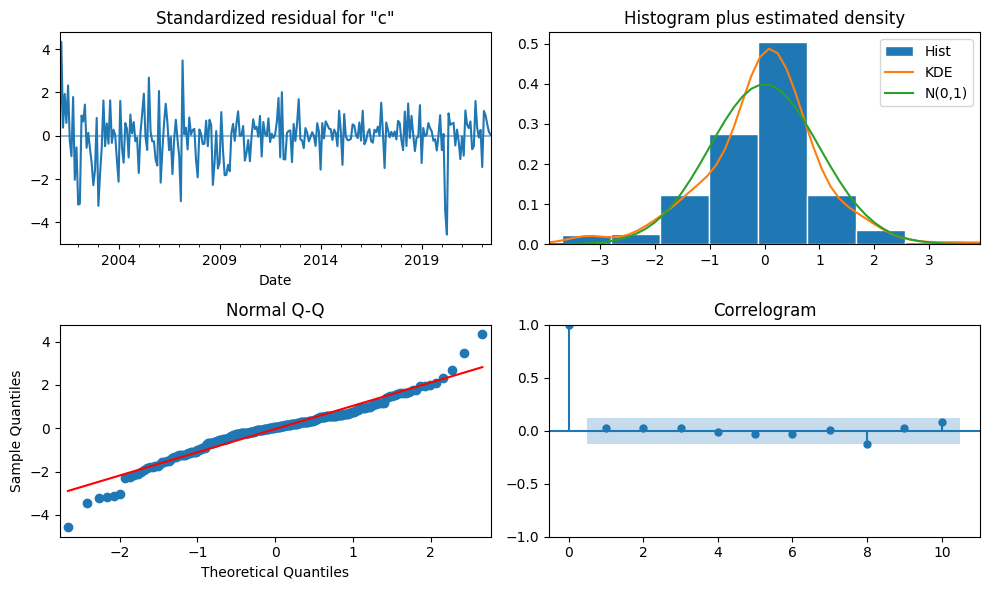

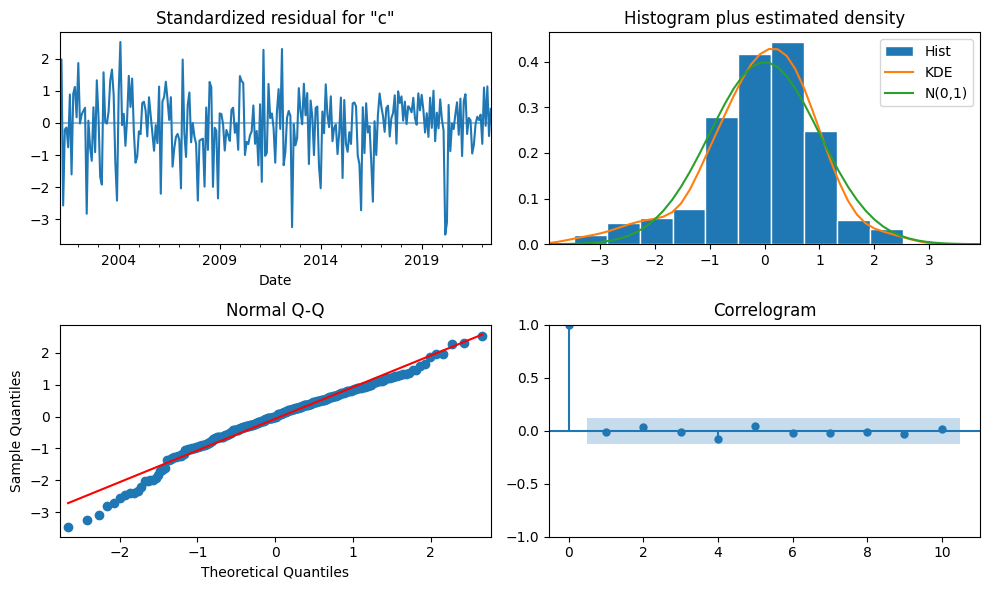

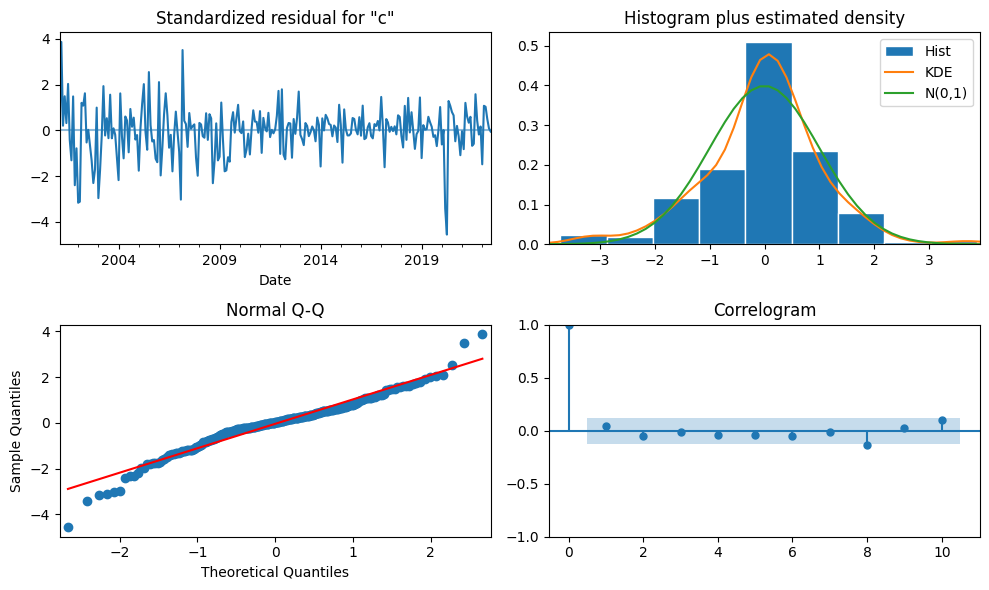

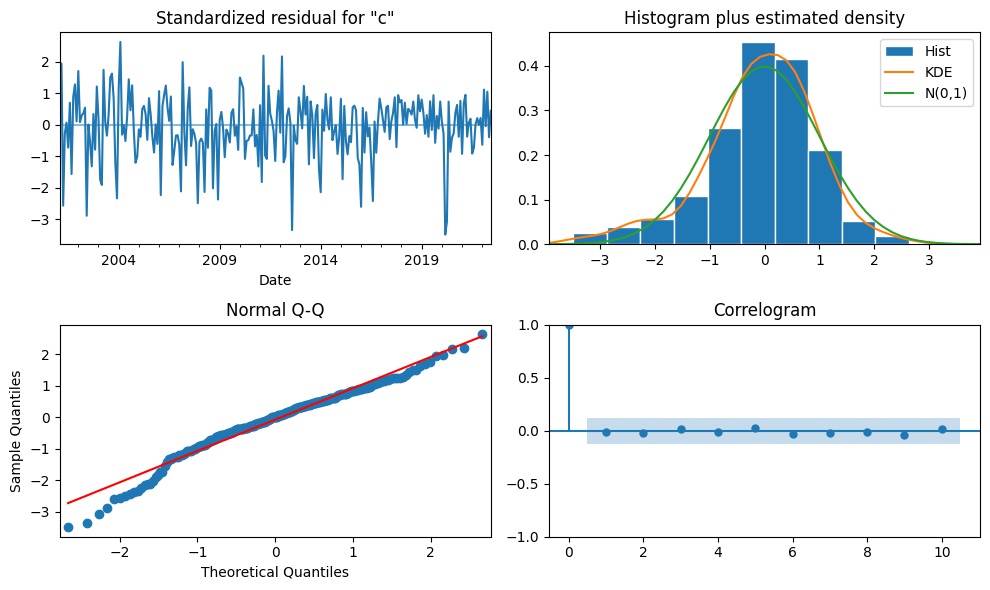

In [86]:
# diagnostic analysis
## total model
fig = model_total.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();
## narcotics model
fig = model_narco.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();


## tuned total model
fig = auto_total_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();
## tuned narcotics model
fig = auto_narco_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();



```
# Both Tuned and Untuned Total Crime shows significant nlag8 and nlag10

### Either models are best since they output the same metrics with though different AIC

Best Model choices
### narcotics - ARIMA(0,1,4)(1,0,1)[12]
### total crime - ARIMA(0,1,1)(1,0,1)[12]
```



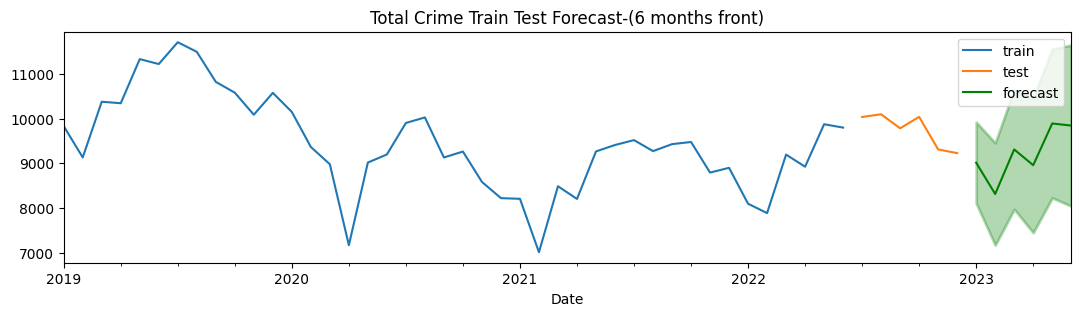

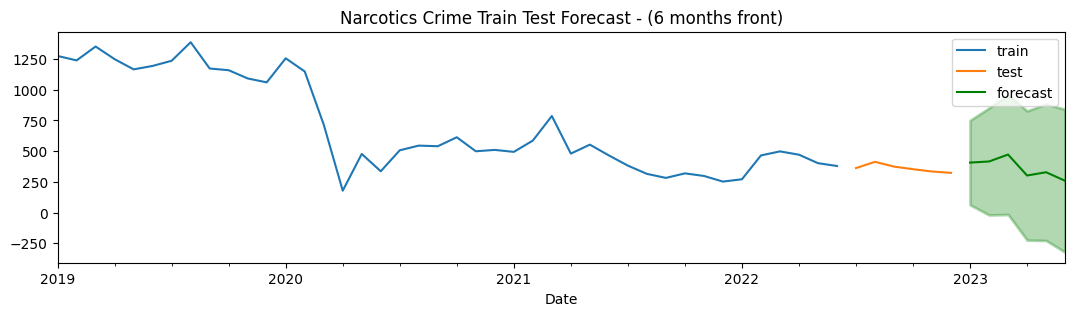

In [91]:
# Making true future forecasts using the entire dataset
### Future forecast for the 6 months front
narco_future_model = tsa.ARIMA(narco_ts, order=pdq_narco, seasonal_order=PDQm_tune_narco).fit()
total_future_model = tsa.ARIMA(total_crime_ts, order=pdq_tune_total, seasonal_order=PDQm_total).fit()

## forecast
narco_future_fore = narco_future_model.get_forecast(len(test_narco)).summary_frame()
total_future_fore = total_future_model.get_forecast(len(test_total)).summary_frame()

## plot forecast
## total plot
plot_forecast(train_total.loc['2019':], test_total, total_future_fore, title='Total Crime Train Test Forecast-(6 months front)', figsize=(13, 3));
## narco plot
plot_forecast(train_narco.loc['2019':], test_narco, narco_future_fore, title='Narcotics Crime Train Test Forecast - (6 months front)', figsize=(13, 3));

In [92]:
# start - end dates
narco_future_fore.index[0], narco_future_fore.index[-1], total_future_fore.index[0], total_future_fore.index[-1]

(Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-06-30 00:00:00'))

In [105]:
narco_future_fore['mean'].loc[narco_future_fore.index[-1]]

258.53575548340365

In [112]:
import math as m

# Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
val_nar = narco_future_fore['mean'].loc[narco_future_fore.index[-1]]
val_tot = total_future_fore['mean'].loc[total_future_fore.index[-1]]
if val_nar > val_tot:
  print('>>> Narcotics has the highest monthly count at the end of the forecast')
else:
  print('>>> Total Crime has the highest monthly count at the end of the forecast')
print()
### Total Crime
# start - end values
start = total_future_fore['mean'].iloc[0]
end = total_future_fore['mean'].iloc[-1]

# change in total crime
delta_tot = end - start
# monthly change
delta_month_tot = delta_tot/6
# percent change
perc_tot = (delta_tot/start) * 100


### narcotics cime
# from the graph we see a drop so we need an absolute
# start - end values
start_val = narco_future_fore['mean'].iloc[0]
end_val = narco_future_fore['mean'].iloc[-1]

# change in narcotics crime
delta_nar = m.fabs(end_val - start_val)
# monthly change
delta_month_nar = delta_nar/6
# percent change
perc_nar = (delta_nar/start_val) * 100



# Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
if delta_nar > delta_tot:
  print('>>> Narcotics has the highest net change at the end of the forecast')
else:
  print('>>> Total Crime has the highest net change at the end of the forecast')
print()

# Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
if perc_nar > perc_tot:
  print('>>> Narcotics has the highest percent change at the end of the forecast')
else:
  print('>>> Total Crime has the highest percent change at the end of the forecast')
print()


print('Report to stakeholders ')
# What is the predicted total crime 6 months into the future (beyond the dataset)?
# What is the percent change in total crime by the end of the 6-month forecast (beyond the dataset)?
print(f'''>>> The Total crime rate will increase by {perc_tot :.2f}% which is {delta_tot :.0f} in 6 months time from {total_future_fore.index[0].strftime('%B %d %Y')}
This can be seen by the forecast graph plot''')
print()

# What is the predicted Narcotics crime 6 months into the future (beyond the dataset)?
# What is the percent change in Narcotics crime by the end of the 6-month forecast (beyond the dataset)?
print(f'''>>> The Narcotics crime rate will decrease by {perc_nar :.2f}% which is {delta_nar :.0f} in 6 months time from {narco_future_fore.index[0].strftime('%B %d %Y')}
The forecast graph thus back it up''')

>>> Total Crime has the highest monthly count at the end of the forecast

>>> Total Crime has the highest net change at the end of the forecast

>>> Narcotics has the highest percent change at the end of the forecast

Report to stakeholders 
>>> The Total crime rate will increase by 9.21% which is 830 in 6 months time from January 31 2023
This can be seen by the forecast graph plot

>>> The Narcotics crime rate will decrease by 36.46% which is 148 in 6 months time from January 31 2023
The forecast graph thus back it up




```
# The Negative sign shows a decrease in Narcotics Crime
```

